<a href="https://colab.research.google.com/github/junheecho-zz/play2021/blob/master/Training_Grape_Type_Classifier_with_GradCAM_(TensorFlow_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference

1. [Visual explanations GradCAM / GradCAM++ / ScoreCAM (kaggle)](https://www.kaggle.com/itoeiji/visual-explanations-gradcam-gradcam-scorecam)
1. [Available models in keras](https://keras.io/api/applications/)
1. [한옥, 모던 인테리어 데이터셋 만들기 (amuro)](https://colab.research.google.com/drive/1Z93QEN9uGt0TfgdosCgTYXACWrouc-_m?usp=sharing)
1. [transfer learning](https://keras.io/guides/transfer_learning/)
1. [tensorboard 를 활용한 과적합여부 확인](https://tykimos.github.io/2017/07/09/Training_Monitoring/)
1. [dog vs cat classifier + Grad CAM (tf2.0)](https://www.kaggle.com/nguyenhoa/dog-cat-classifier-gradcam-with-tensorflow-2-0)
1. [21/09/08 Design Style Classifier](https://colab.research.google.com/drive/1EfJnfmlM3nP4SzcxAZKDgEqKmq-7Cg-E?usp=sharing)

# Keras Image Recognition: grape type

## 1) Download grape dataset

In [28]:
%%capture
!rm -rf grape_dataset
!wget https://www.dropbox.com/s/cdle49xzq3kcwnq/grape-dataset.tar.gz?dl=0 -O grape_dataset.tar.gz
!tar xvfz grape_dataset.tar.gz
# Load the TensorBoard notebook extension
%load_ext tensorboard

## 2) Training part using Keras and pre-trained model

###  Load Python Library and keras

In [29]:
import os, copy, datetime, time, glob
import warnings
warnings.filterwarnings('ignore')
 
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, Conv2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Set Training Parameter

In [ ]:
import os
dataset_dir = '/content/grape-dataset'
trainingset_dir = dataset_dir
testset_dir = dataset_dir

# 학습과정 및 모델 결과를 구글 드라이브에 저장하기 위한 용도
log_dir = '/content/drive/MyDrive/w2/grape-type/logs'

epochs = 5

# 아래부터는 기본값으로 사용해도 괜찮습니다.

batch_size = 32
learning_rate = 5e-5
W = 224 # The default size for ResNet is 224
H = 224 # The default size for ResNet is 224
seed = 1234   # deterministic result
 
# sub-directory names under trainingset_dir

# ['concord grape', 'crimson grape', 'shine msucat grape', 'thompson seedless grape']
class_names = list(sorted(os.listdir(trainingset_dir)))

class_to_label = dict([(i, class_name) for i, class_name in enumerate(class_names)])
label_to_class = dict([(class_name, i) for i, class_name in enumerate(class_names)])
 
n_classes = len(label_to_class) 
 
# verify directory existence
assert os.path.exists(trainingset_dir)
assert os.path.exists(testset_dir)
 
print ('label_to_class', label_to_class)
print ('class_to_label', class_to_label)

# distribution
print ('# of images for each class')
for category in class_names:
  print (category, len(os.listdir(os.path.join(trainingset_dir, category))))

label_to_class {'concord grape': 0, 'crimson grape': 1, 'shine muscat grape': 2, 'thompson seedless grape': 3}
class_to_label {0: 'concord grape', 1: 'crimson grape', 2: 'shine muscat grape', 3: 'thompson seedless grape'}
# of images for each class
concord grape 440
crimson grape 578
shine muscat grape 460
thompson seedless grape 386


### Verifying image loading test

In [30]:
from PIL import Image
import tqdm

def get_failed_images(root_dir):
  class_names = os.listdir(root_dir)
  failed_files = []
  for category in class_names:
    files = [os.path.join(root_dir, category, file) for file in os.listdir(os.path.join(root_dir, category))]
    for file in tqdm.tqdm(files):
      try:
        #print ('.', end='')
        Image.open(file).load()
      except Exception as ex:
        #print ('fail', file)
        failed_files += [file]
  print ('done')
  return failed_files

# fail /content/grape-dataset/shine muscat grape/0043.jpg

#dataset_dir = '/content/grape-dataset'
failed_files = get_failed_images(dataset_dir)

print ('\nfailed_files', failed_files)
# rename failed files 
for file in failed_files:
  src = file
  dest = src[:-4] + '.error'
  print ('reanme', src, 'to', dest)
  os.rename(src, dest)

100%|██████████| 461/461 [00:09<00:00, 47.36it/s]

done

failed_files ['/content/grape-dataset/shine muscat grape/0043.e.e.error', '/content/grape-dataset/shine muscat grape/0043.e.e.e.e.error', '/content/grape-dataset/shine muscat grape/0043.jpg']
reanme /content/grape-dataset/shine muscat grape/0043.e.e.error to /content/grape-dataset/shine muscat grape/0043.e.e.e.error
reanme /content/grape-dataset/shine muscat grape/0043.e.e.e.e.error to /content/grape-dataset/shine muscat grape/0043.e.e.e.e.e.error
reanme /content/grape-dataset/shine muscat grape/0043.jpg to /content/grape-dataset/shine muscat grape/0043.error


Found 747 images belonging to 4 classes.
Found 184 images belonging to 4 classes.


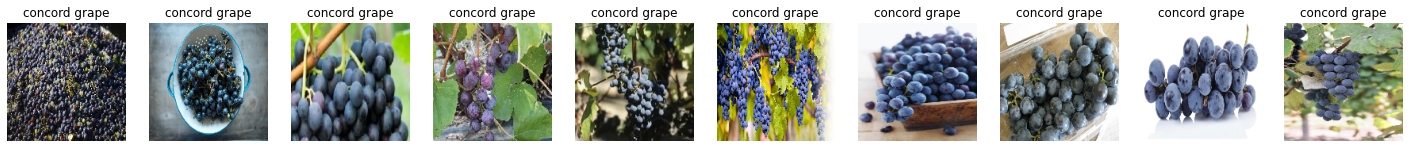

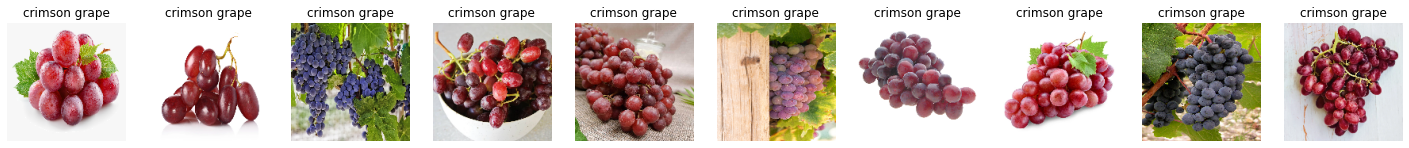

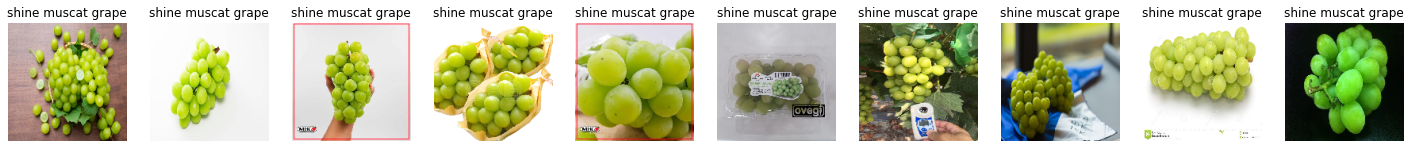

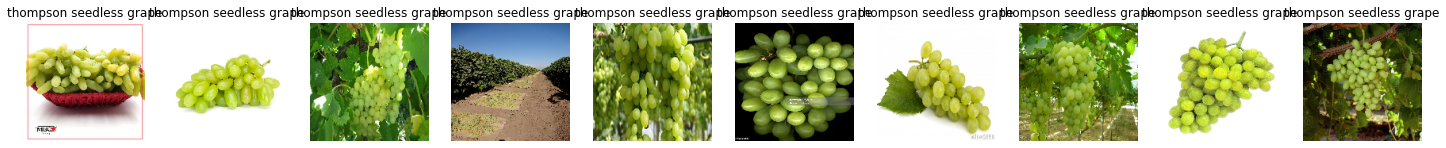

In [31]:
## to image data generator
 
# See also https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=10,                        # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,      # randomly flip images vertically
    validation_split=0.2
)
  
train_generator = datagen_train.flow_from_directory(
    trainingset_dir, 
    subset='training',
    target_size=(W, H), class_mode="categorical", batch_size=batch_size, seed=seed)
 
validation_generator = datagen_train.flow_from_directory(
    trainingset_dir, 
    subset='validation',
    shuffle=False,
    target_size=(W, H), class_mode="categorical", batch_size=batch_size, seed=seed)
 
# Visualize training sample
for class_name in class_names:
    n_cols = 10 # samples per class
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))
    directory = trainingset_dir + '/' + class_name
    assert os.path.exists(directory)
    image_files = glob.glob(directory + '/*.jpg')[:n_cols]
 
    for i in range(n_cols):
        image_file = image_files[i]
        image = load_img(image_file, target_size=(150, 150))
        axs[i].imshow(np.uint8(image))
        axs[i].axis('off')
        axs[i].set_title(class_name)
 
    plt.show()

### Training (Transfer learning)

#### Loss function

[CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)
Computes the crossentropy loss between the labels and predictions.

> Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation. 

```python
>>> y_true = [[0, 1, 0], [0, 0, 1]]
>>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
>>> # Using 'auto'/'sum_over_batch_size' reduction type.
>>> cce = tf.keras.losses.CategoricalCrossentropy()
>>> cce(y_true, y_pred).numpy()
1.177
```

#### Optimizer

[Adam](https://keras.io/api/optimizers/adam/)
> Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

> According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

#### Metric

[Accuracy](https://keras.io/api/metrics/accuracy_metrics/)

Calculates how often predictions equal labels.

#### Model

See also [dog vs cat classifier + Grad CAM (tf2.0)](https://www.kaggle.com/nguyenhoa/dog-cat-classifier-gradcam-with-tensorflow-2-0)

In [32]:
#units: Positive integer, dimensionality of the output space.
def build_model(units):
  resnet = ResNet50(include_top=False, pooling="avg", weights='imagenet')
  # https://www.kaggle.com/itoeiji/visual-explanations-gradcam-gradcam-scorecam
  # 새로운 데이터셋에 적응시키기 위해 BatchNormalization 부분은 학습하도록 설정
  for layer in resnet.layers[:-10]:
    layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable  
  # 원래 코드는 아래와 같이 모두 freeze 시킨 상태에서 transfer learning. 그 뒤에 추가 학습할 때 True 로 바꿈.
  '''
  for layer in resnet.layers:
    layer.trainable=False
  '''

  logits = Dense(units)(resnet.layers[-1].output)
  output = Activation('softmax')(logits)
  model = Model(resnet.input, output)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
 
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

units = len(class_names)
model = build_model(units)

### training

In [ ]:
#tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()
 
# delete hidden file .ipynb_checkpoints if any. 
!rm -rf {trainingset_dir}/.ipynb_checkpoints/
 
def train_model(model, epochs, log_dir='logs/'):
  log_dir_root = log_dir
  time_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  log_dir = os.path.join(log_dir, time_string)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=log_dir + '/best_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True)
 
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min')
  
  print ('log_dir', log_dir)
  #print ('traing.samples', train_generator.samples, 'steps_per_epoch', train_generator.samples // batch_size)
  #print ('validation.samples', validation_generator.samples, 'validation_steps',validation_generator.samples // batch_size)
  history = model.fit_generator(
      train_generator,
      #steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      #validation_steps = validation_generator.samples // batch_size,
      epochs=epochs,
      callbacks=[tensorboard_callback, 
                 #early_stopping, 
                 model_checkpoint_callback]
  )
  last_saved_model = log_dir_root + '/' + time_string + f'_epochs{epochs}.h5'
  model.save(last_saved_model)
  print ('last saved model', last_saved_model)
  return history

units = len(class_names)
model = build_model(units=units)
 
s = time.time()
history = train_model(model, epochs, log_dir)
elapsed = time.time()-s
print (f'elapsed time: {elapsed} sec, {(elapsed / epochs)} sec for single epoch' )

log_dir /content/drive/MyDrive/w2/grape-type/logs/20211001-083815
Epoch 1/5
24/24 [==============================] - 525s 21s/step - loss: 1.2295 - accuracy: 0.4873 - val_loss: 0.8082 - val_accuracy: 0.6902
Epoch 2/5
24/24 [==============================] - 480s 20s/step - loss: 0.6625 - accuracy: 0.7631 - val_loss: 0.4792 - val_accuracy: 0.8315
Epoch 3/5
24/24 [==============================] - 471s 20s/step - loss: 0.4886 - accuracy: 0.8420 - val_loss: 0.3564 - val_accuracy: 0.8750
Epoch 4/5
24/24 [==============================] - 482s 20s/step - loss: 0.3980 - accuracy: 0.8688 - val_loss: 0.3620 - val_accuracy: 0.8641
Epoch 5/5
24/24 [==============================] - 480s 20s/step - loss: 0.3520 - accuracy: 0.8822 - val_loss: 0.3377 - val_accuracy: 0.8804
last saved model /content/drive/MyDrive/w2/grape-type/logs/20211001-083815_epochs5.h5
elapsed time: 2499.1311292648315 sec, 499.82622585296633 sec for single epoch


In [ ]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
 
print ('history keys', history.history.keys())
fig, loss_ax = plt.subplots()
 
acc_ax = loss_ax.twinx()
 
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
 
acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
 
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
 
plt.show()

In [ ]:
# see also https://tykimos.github.io/2017/07/09/Training_Monitoring/
%tensorboard --logdir {log_dir}

## 3) Prediction with Grad CAM, Guided Backprop

### Define Confusion Matrix, Grad CAM, Guided Backprop and Prediction Function

In [33]:
# https://s00hyun.github.io/ml&dl/keras-confusion-matrix-doesn't-match/
def show_confusion_matrix(model, validation_generator):
  validation_generator.reset()
  
  y_preds = model.predict(validation_generator)
  y_preds = np.argmax(y_preds, axis=1)
  y_trues = validation_generator.classes
  cm = confusion_matrix(y_trues, y_preds)
  
  fig, ax = plt.subplots(figsize=(7, 6))
  
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)
  
  ax.set(
      xticklabels=list(label_to_class.keys()),
      yticklabels=list(label_to_class.keys()),
      title='confusion matrix',
      ylabel='True label',
      xlabel='Predicted label'
  )
  params = dict(rotation=45, ha='center', rotation_mode='anchor')
  plt.setp(ax.get_yticklabels(), **params)
  plt.setp(ax.get_xticklabels(), **params)
  plt.show()

import random
 
# https://www.kaggle.com/nguyenhoa/dog-cat-classifier-gradcam-with-tensorflow-2-0?scriptVersionId=39776976&cellId=20
class GradCAM:
    # Adapted with some modification from https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    def __init__(self, model, layerName=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layerName = layerName
            
        if self.layerName == None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")
            
    def compute_heatmap(self, image, classIdx, upsample_size, eps=1e-5):
        gradModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )
        # record operations for automatic differentiation
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOuts, preds) = gradModel(inputs) # preds after softmax
            loss = preds[:,classIdx]
        
        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, convOuts)
        # discard batch
        convOuts = convOuts[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))
        
        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOuts), axis=-1)
        
        # Apply reLU
        cam = np.maximum(cam, 0)
        #cam = tf.math.maximum(cam, 0)
        cam = cam/np.max(cam)
        cam = cv2.resize(cam, upsample_size,interpolation=cv2.INTER_LINEAR)
        
        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1,1,3])
        
        return cam3
    
def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255*cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
    
    new_img = 0.3*cam3 + 0.5*img
    
    return (new_img*255.0/new_img.max()).astype("uint8")
 
def show_gradCAMs(model, gradCAM, GuidedBP, im_ls, n=3, decode={}):
    """
    model: softmax layer
    """
    random.shuffle(im_ls)
    n = min(len(im_ls), n)
    plt.subplots(figsize=(15, 7*n))
    k = 1
    fontsize = 15

    for i in range(n):
        img = cv2.imread(im_ls[i])
        upsample_size = (img.shape[1],img.shape[0])
 
        # Show original image
        plt.subplot(n,3,k)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        filename = os.path.basename(im_ls[i])
        plt.title(f"{filename}", fontsize=fontsize)
        plt.axis("off")
        # Show overlayed grad
        plt.subplot(n,3,k+1)
        im = img_to_array(load_img(im_ls[i], target_size=(W,H)))
        x = np.expand_dims(im, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        idx = preds.argmax()
        if len(decode)==0:
            res = decode_predictions(preds)[0][0][1:]
        else:
            res = [decode[idx],preds.max()]
        cam3 = gradCAM.compute_heatmap(image=x, classIdx=idx, upsample_size=upsample_size)
        new_img = overlay_gradCAM(img, cam3)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
        label = res[0]
        prob = res[1] * 100
        plt.title(f"GradCAM - Pred: {label}. Prob: {prob:.1f} %", fontsize=fontsize)
        plt.axis("off")
        
        # Show guided GradCAM
        plt.subplot(n,3,k+2)
        gb = GuidedBP.guided_backprop(x, upsample_size)
        guided_gradcam = deprocess_image(gb*cam3)
        guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)
        plt.imshow(guided_gradcam)
        plt.title("Guided GradCAM", fontsize=fontsize)
        plt.axis("off")
        
        k += 3
    plt.show()

@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Reference: https://github.com/eclique/keras-gradcam with adaption to tensorflow 2.0  
class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()
        
        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Confusion Matrix

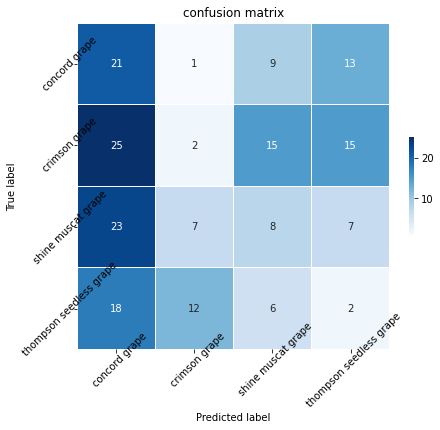

In [ ]:
show_confusion_matrix(model, validation_generator)

### Prediction

In [ ]:
model_logit = Model(model.input,model.layers[-2].output)
retrained_gradCAM = GradCAM(model=model_logit, layerName="conv5_block3_out")
retrained_guidedBP = GuidedBackprop(model=model, layerName="conv5_block3_out")
 
testfiles = glob.glob(testset_dir + '/*.jpg') + glob.glob(testset_dir + '/*.jpeg')
#decode={0:"hanok", 1:"moderninterior"}
show_gradCAMs(model, retrained_gradCAM,retrained_guidedBP,testfiles, n=5, decode=class_to_label)

## 4) Load trained model and predict test images

### Load trained model

In [34]:
tf.keras.backend.clear_session()

# 새로 학습한 모델 경로를 지정해야 합니다.
trained_model = '/content/drive/MyDrive/w2/grape-type/logs/20211001-083815_epochs5.h5'
#from tensorflow import keras 
assert os.path.exists(trained_model)
 
trained_model = tf.keras.models.load_model(trained_model)

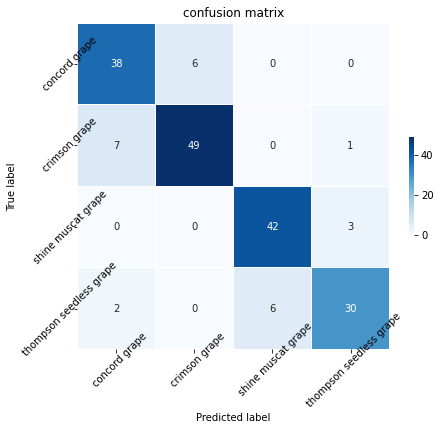

In [ ]:
show_confusion_matrix(trained_model, validation_generator)

### Predict test images with Grad-CAM

testset_dir /content/grape-dataset


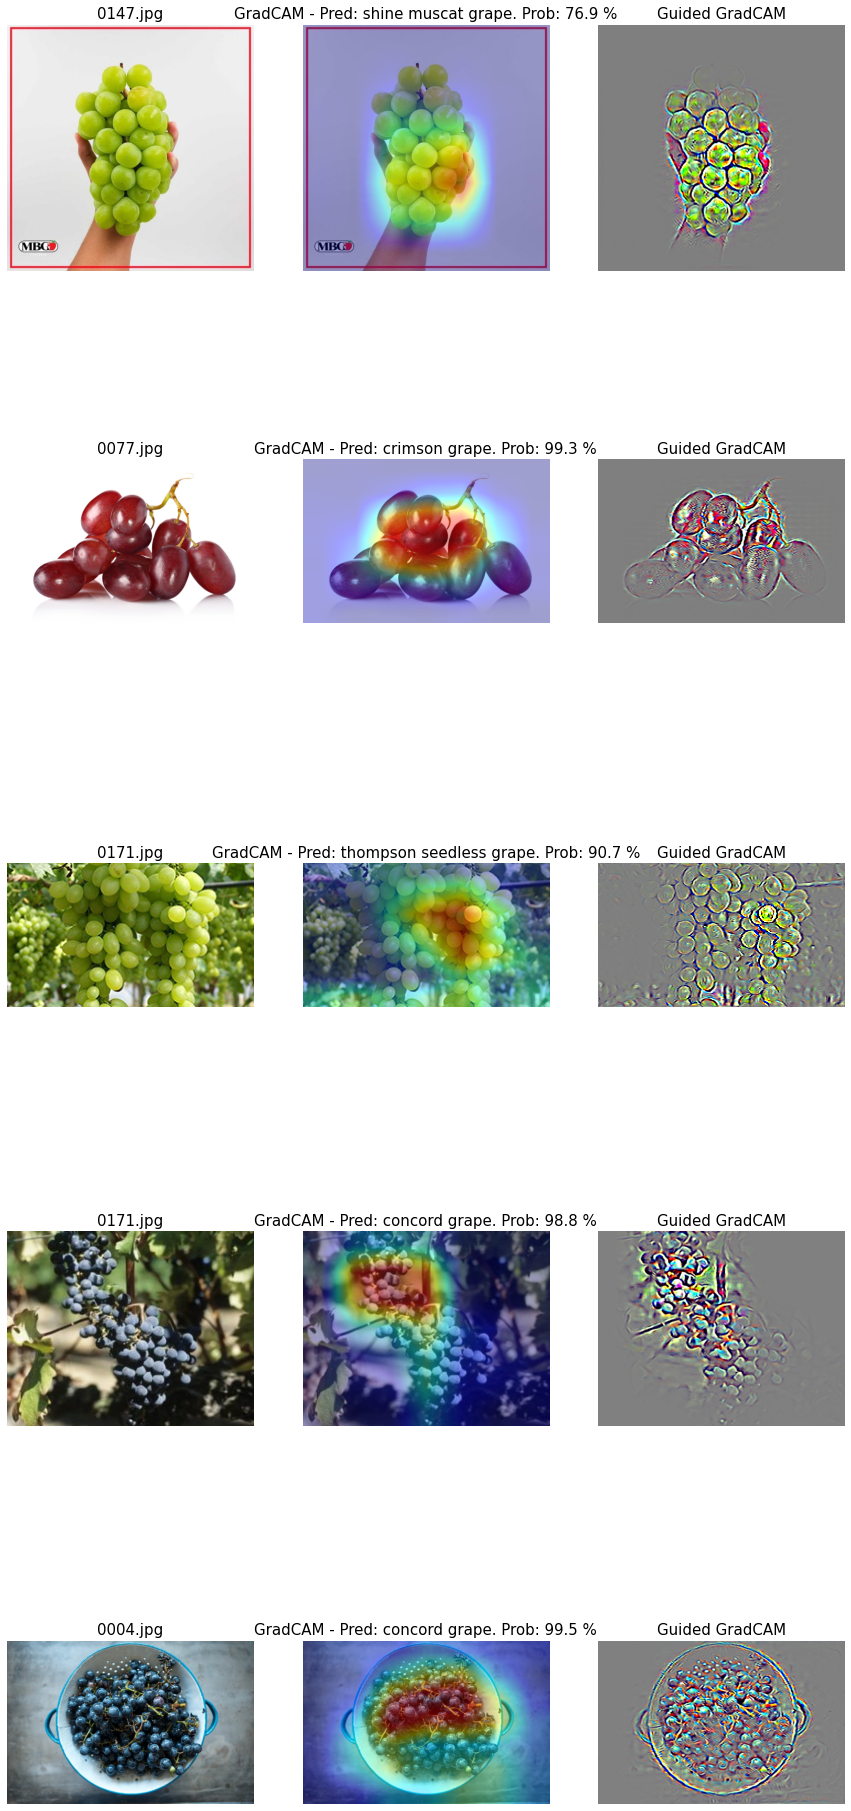

In [36]:

# 임시로 학습데이터셋 영상으로 추론결과보기
#
testset_dir = dataset_dir
print ('testset_dir', testset_dir)
 
assert os.path.exists (testset_dir)

# predict test images with Grad CAM
# take 5 images for each category
testfiles = []
for category in class_names:
  dir = os.path.join(dataset_dir, category)
  testfiles += [os.path.join(dir, file) for file in os.listdir(dir) if '.jpg' in file][:5]

#test_images = glob.glob(testset_dir + '/*.jpg') 
 
# confusion matrix
#show_confusion_matrix(trained_model, validation_generator)
  
model_logit = Model(trained_model.input,trained_model.layers[-2].output)
retrained_gradCAM = GradCAM(model=model_logit, layerName="conv5_block3_out")
retrained_guidedBP = GuidedBackprop(model=model, layerName="conv5_block3_out")
show_gradCAMs(trained_model, retrained_gradCAM,retrained_guidedBP,testfiles, n=5, decode=class_to_label)